#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [ ]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_test, y_test
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [ ]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'Qty_2day'
    x = data.drop(target, axis = 1)
    y = data.loc[:, target]

    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 60, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
# 44번 매장의 12번 상품
sales_44 = sales[sales['Store_ID']==44]
sales_44_3 = sales_44[sales_44['Product_ID']==3]
# 요일, 달, 연도 추가
sales_44_3['week'] = sales_44_3['Date'].dt.day_name()
sales_44_3['month'] = sales_44_3['Date'].dt.month
# 구매자수 추가
sales_44_3 = pd.merge(sales_44_3, orders, how='left')
# 유가데이터를 그냥 병합하면 너무 많은 데이터가 날라감. (왼쪽데이터는 다 살림)
sales_44_3 = pd.merge(sales_44_3, oil_price, how='left')
# 7일 (이동)평균, 이틀후 변화량, 판매량(target)
sales_44_3['Qty_mean_7'] = sales_44_3['Qty'].rolling(7, min_periods=1).mean()
sales_44_3['Qty_diff'] = sales_44_3['Qty'].shift(-2) - sales_44_3['Qty']
sales_44_3['Qty_2day'] = sales_44_3['Qty'].shift(-2)
# 필요없는 열 삭제
sales_44_3.drop(['Store_ID', 'Product_ID'], axis=1, inplace=True)

In [ ]:
# NaN 조치 (CustomerCount, WTI_Price, Qty_diff)
sales_44_3['CustomerCount'] = sales_44_3['CustomerCount'].fillna(method='ffill', limit=7)
sales_44_3['WTI_Price'].fillna(method='ffill', inplace=True)
sales_44_3.dropna(axis=0, inplace=True)
# 'Date' 컬럼 인덱스로 넣기 + 가변수화
sales_44_3.set_index('Date', inplace=True)
sales_44_3 = pd.get_dummies(sales_44_3, columns = ['week'], drop_first=True, dtype=int)

* **모델링**

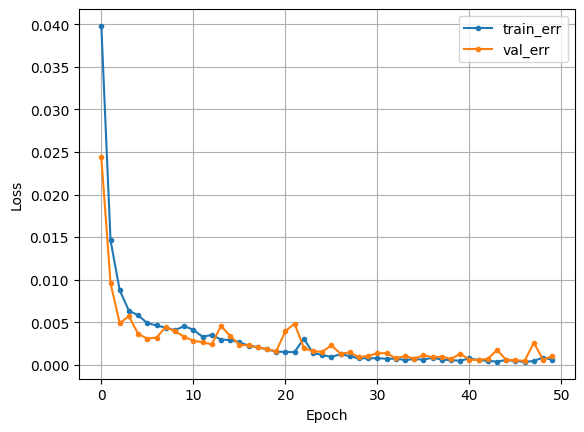

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_44_3, timesteps, True)
_, ts, nfeat = x_train.shape
#모델링
clear_session()
model03_01 = Sequential([LSTM(128, input_shape = (ts, nfeat),activation='relu'),
                         Dense(64, activation='relu'),
                         Dense(32, activation='relu'),
                         Dense(16, activation='relu'),
                         Dense(8, activation='relu'),
                         Dense(1)])

model03_01.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')
history = model03_01.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0).history
dl_history_plot(history)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_val2, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 [==============================] - 0s 9ms/step
RMSE:  1275.8268188361135
MAE :  812.2744018554688
MAPE :  2.9025177330379654e+17
R2 :  0.8967350538060025


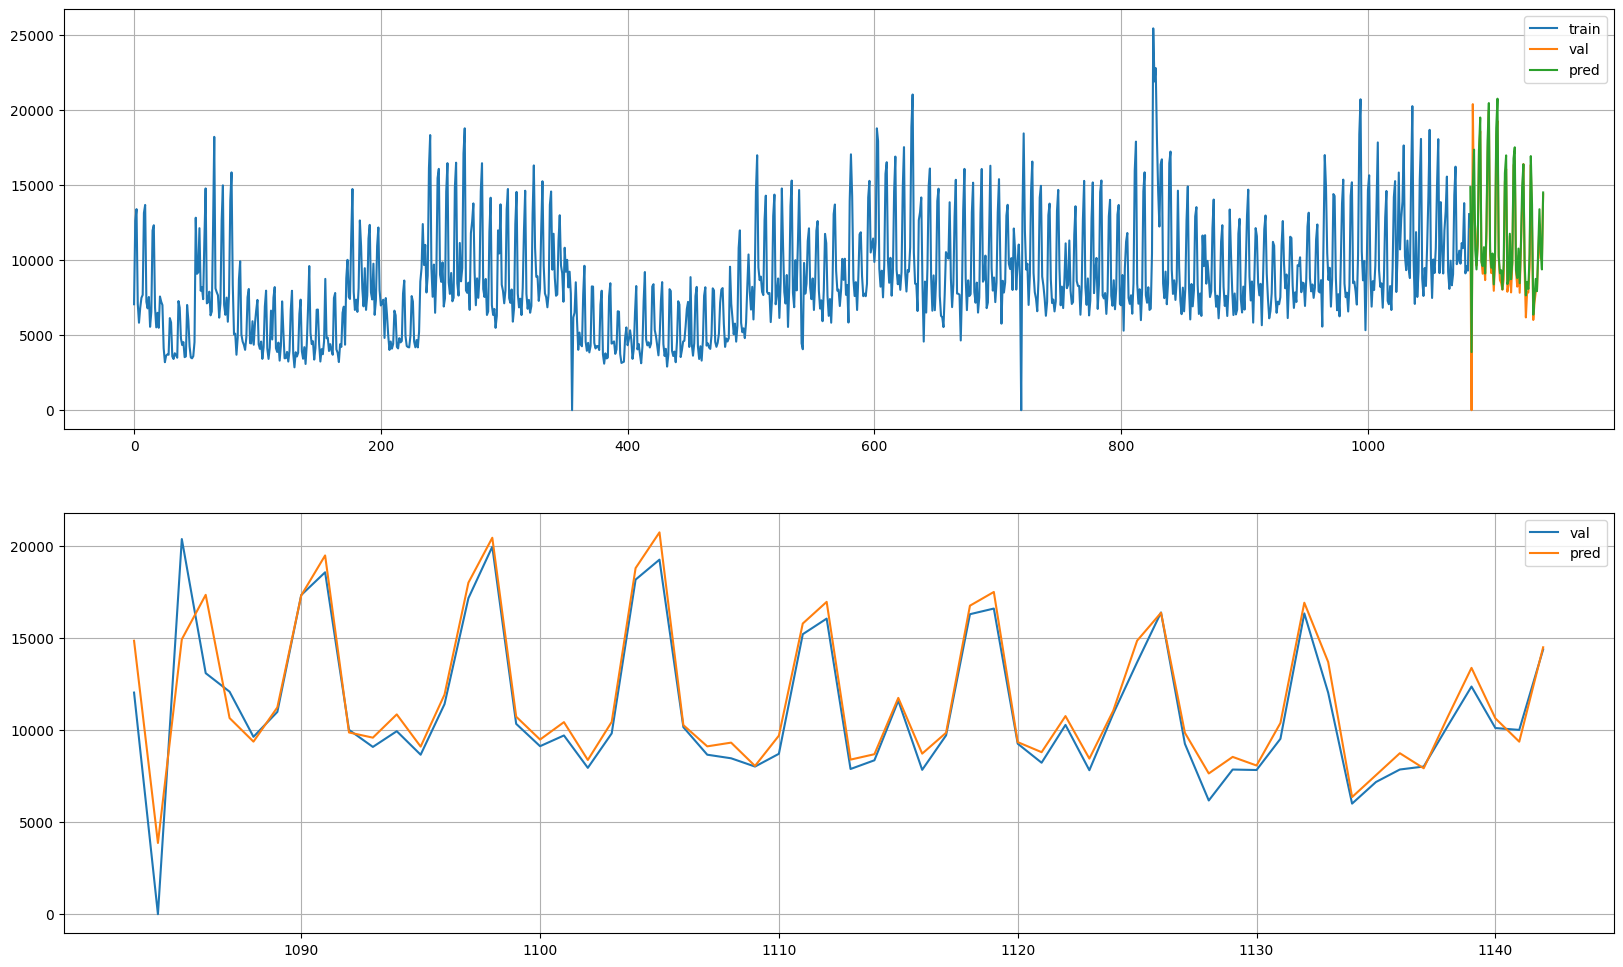

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
# 44번 매장의 12번 상품
sales_44 = sales[sales['Store_ID']==44]
sales_44_12 = sales_44[sales_44['Product_ID']==12]
# 요일, 달, 연도 추가
sales_44_12['week'] = sales_44_12['Date'].dt.day_name()
sales_44_12['month'] = sales_44_12['Date'].dt.month
# 구매자수 추가
sales_44_12 = pd.merge(sales_44_12, orders, how='left')
# 유가데이터를 그냥 병합하면 너무 많은 데이터가 날라감. (왼쪽데이터는 다 살림)
sales_44_12 = pd.merge(sales_44_12, oil_price, how='left')
# 7일 (이동)평균, 이틀후 변화량, 판매량(target)
sales_44_12['Qty_mean_7'] = sales_44_12['Qty'].rolling(7, min_periods=1).mean()
sales_44_12['Qty_diff'] = sales_44_12['Qty'].shift(-2) - sales_44_12['Qty']
sales_44_12['Qty_2day'] = sales_44_12['Qty'].shift(-2)
# 필요없는 열 삭제
sales_44_12.drop(['Store_ID', 'Product_ID'], axis=1, inplace=True)

In [ ]:
# NaN 조치 (CustomerCount, WTI_Price, Qty_diff)
sales_44_12['CustomerCount'] = sales_44_12['CustomerCount'].fillna(method='ffill', limit=7)
sales_44_12['WTI_Price'].fillna(method='ffill', inplace=True)
sales_44_12.dropna(axis=0, inplace=True)
# 'Date' 컬럼 인덱스로 넣기 + 가변수화
sales_44_12.set_index('Date', inplace=True)
sales_44_12 = pd.get_dummies(sales_44_12, columns = ['week'], drop_first=True, dtype=int)

* **모델링**

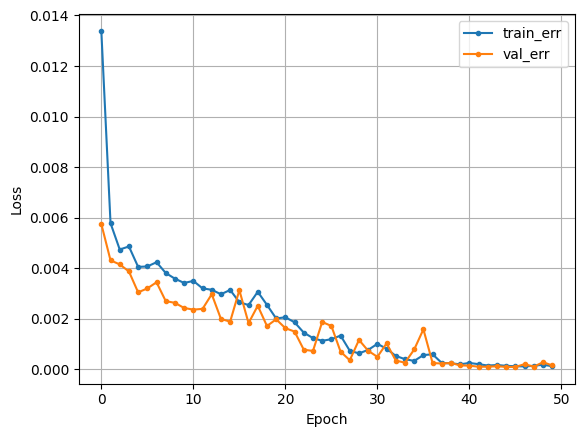

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_44_12, timesteps, True)
_, ts, nfeat = x_train.shape
#모델링
clear_session()
model12_01 = Sequential([LSTM(128, input_shape = (ts, nfeat),activation='relu'),
                         Dense(64, activation='relu'),
                         Dense(32, activation='relu'),
                         Dense(16, activation='relu'),
                         Dense(8, activation='relu'),
                         Dense(1)])

model12_01.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')
history = model12_01.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0).history
dl_history_plot(history)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_val2, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 [==============================] - 0s 9ms/step
RMSE:  868.9117801730572
MAE :  701.1717203776043
MAPE :  2.5784027791424662e+17
R2 :  0.9385613966906203


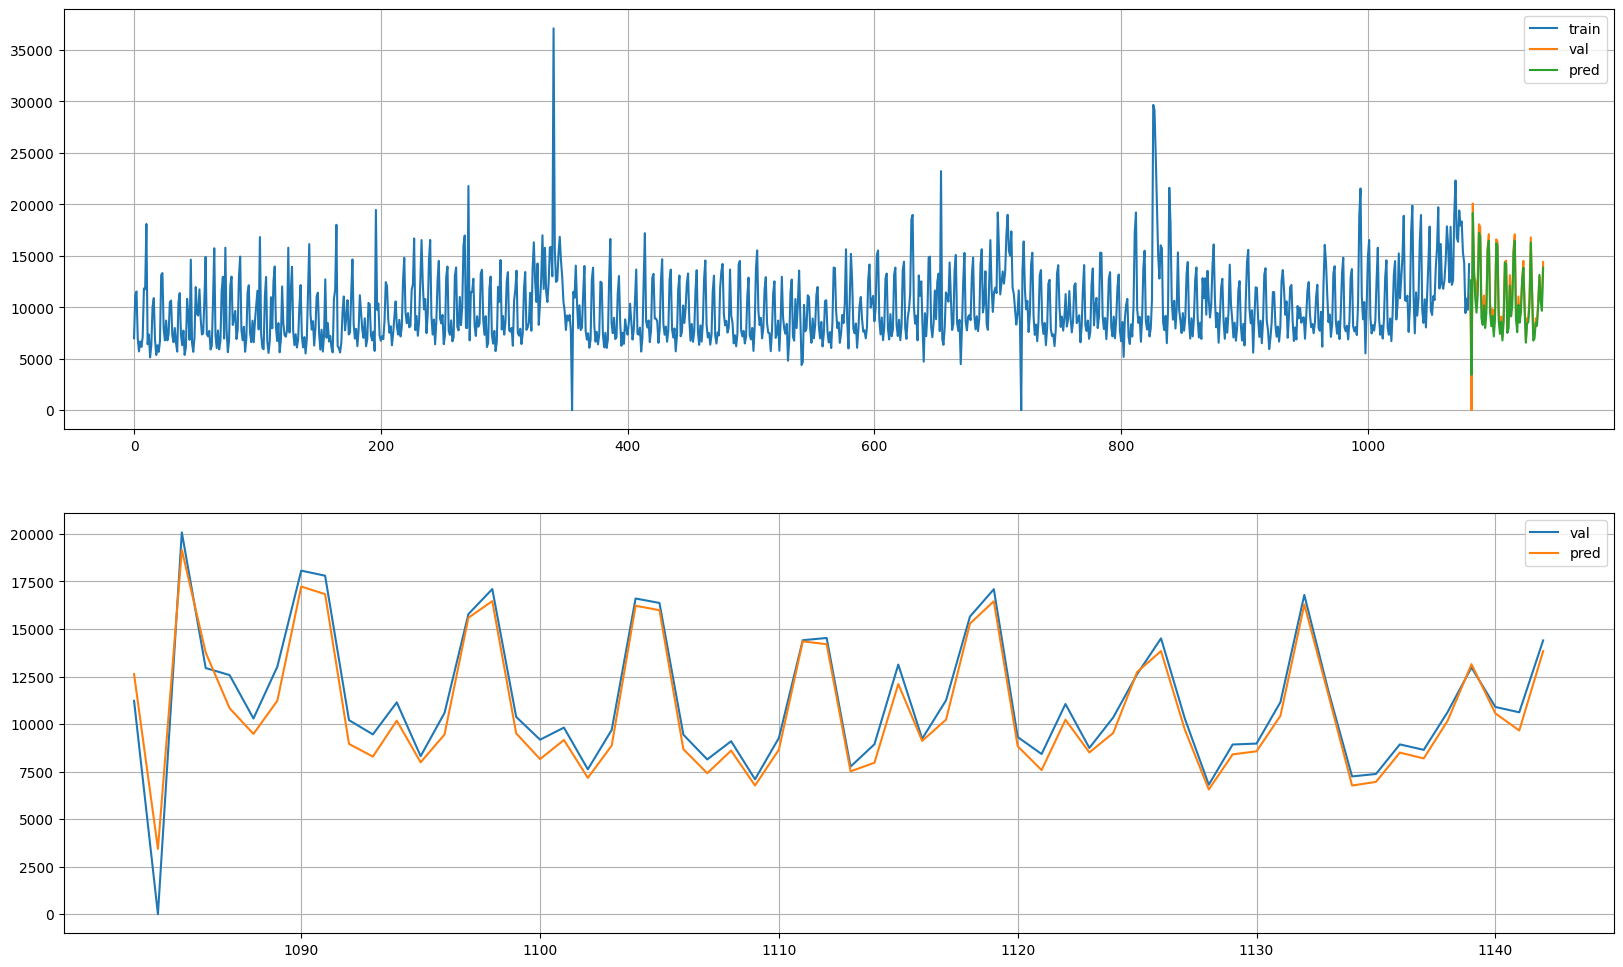

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
# 44번 매장의 12번 상품
sales_44 = sales[sales['Store_ID']==44]
sales_44_42 = sales_44[sales_44['Product_ID']==42]
# 요일, 달, 연도 추가
sales_44_42['week'] = sales_44_42['Date'].dt.day_name()
sales_44_42['month'] = sales_44_42['Date'].dt.month
# 구매자수 추가
sales_44_42 = pd.merge(sales_44_42, orders, how='left')
# 유가데이터를 그냥 병합하면 너무 많은 데이터가 날라감. (왼쪽데이터는 다 살림)
sales_44_42 = pd.merge(sales_44_42, oil_price, how='left')
# 7일 (이동)평균, 이틀후 변화량, 판매량(target)
sales_44_42['Qty_mean_7'] = sales_44_42['Qty'].rolling(7, min_periods=1).mean()
sales_44_42['Qty_diff'] = sales_44_42['Qty'].shift(-2) - sales_44_42['Qty']
sales_44_42['Qty_2day'] = sales_44_42['Qty'].shift(-2)
# 필요없는 열 삭제
sales_44_42.drop(['Store_ID', 'Product_ID'], axis=1, inplace=True)

In [ ]:
# NaN 조치 (CustomerCount, WTI_Price, Qty_diff)
sales_44_42['CustomerCount'] = sales_44_42['CustomerCount'].fillna(method='ffill', limit=7)
sales_44_42['WTI_Price'].fillna(method='ffill', inplace=True)
sales_44_42.dropna(axis=0, inplace=True)
# 'Date' 컬럼 인덱스로 넣기 + 가변수화
sales_44_42.set_index('Date', inplace=True)
sales_44_42 = pd.get_dummies(sales_44_42, columns = ['week'], drop_first=True, dtype=int)

* **모델링**

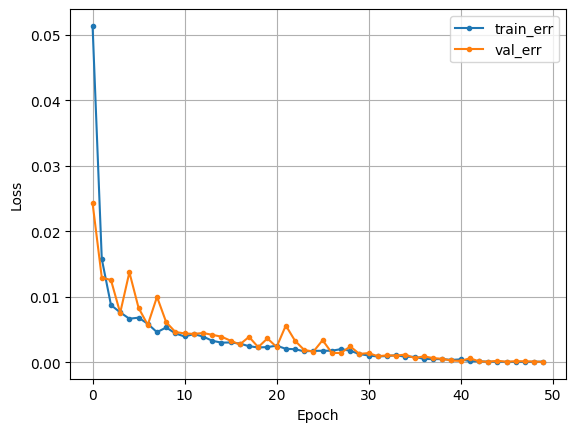

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_44_42, timesteps, True)
_, ts, nfeat = x_train.shape
#모델링
clear_session()
model42_01 = Sequential([LSTM(128, input_shape = (ts, nfeat),activation='relu'),
                         Dense(64, activation='relu'),
                         Dense(32, activation='relu'),
                         Dense(16, activation='relu'),
                         Dense(8, activation='relu'),
                         Dense(1)])

model42_01.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')
history = model42_01.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=0).history
dl_history_plot(history)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_val2, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 [==============================] - 0s 8ms/step
RMSE:  5.621474505249591
MAE :  4.703337160746257
MAPE :  0.0538351161312055
R2 :  0.8626062791346781


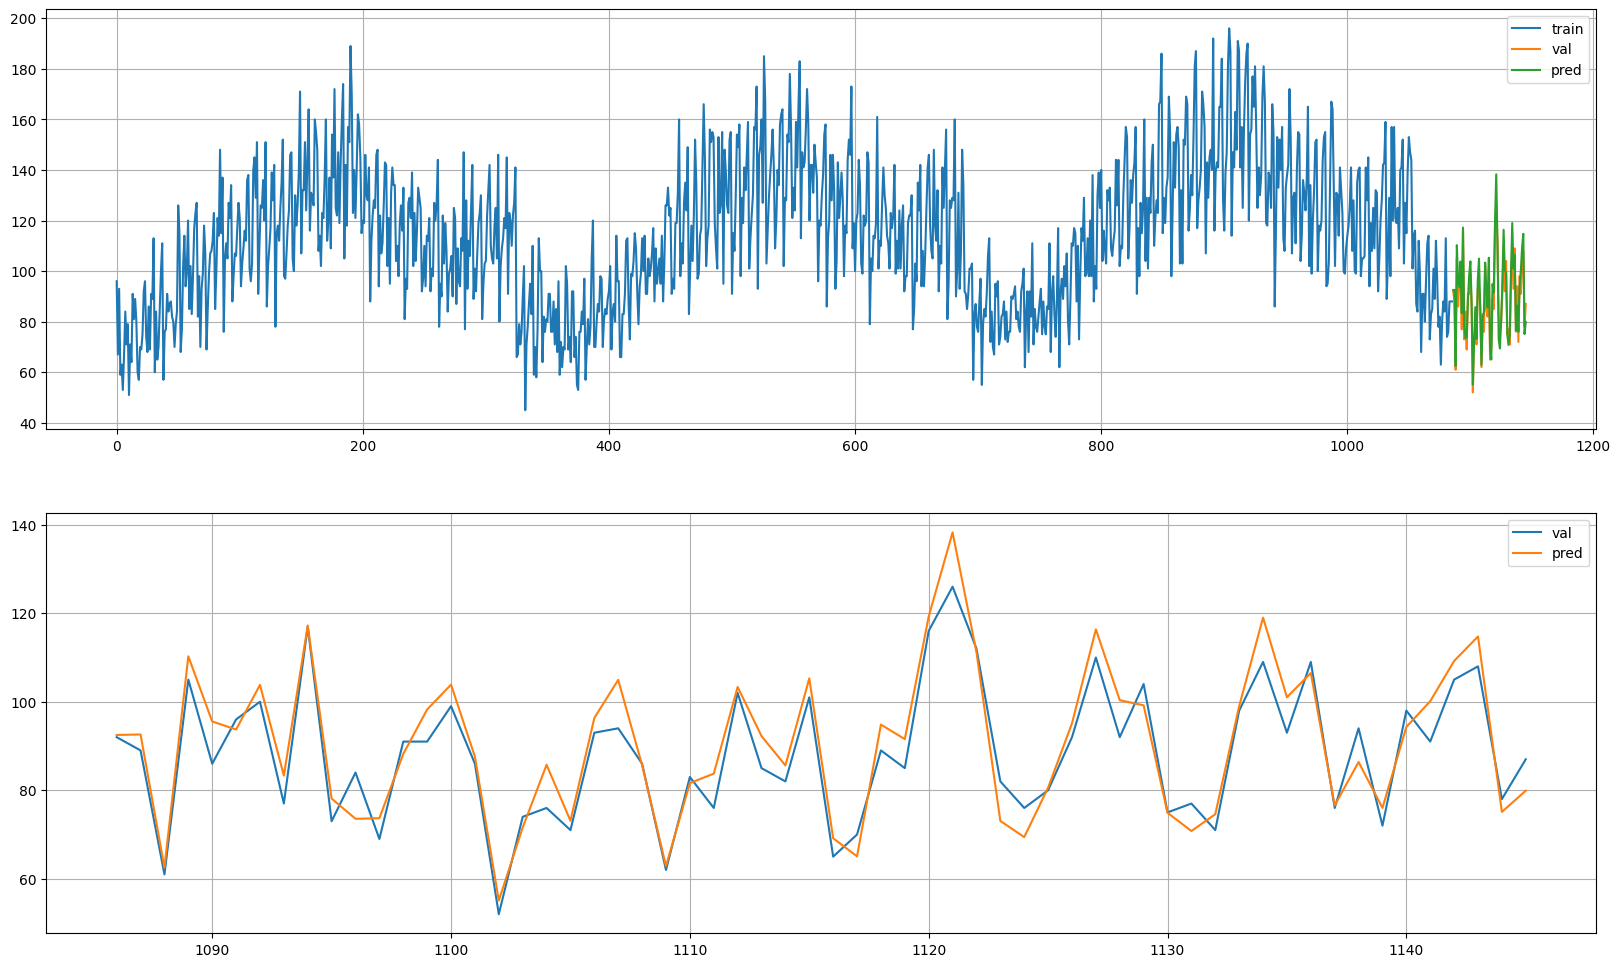

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_44_3, timesteps, True)

(0.0, 25413.0, (1083, 7, 12), (60, 7, 12))

In [ ]:
import keras

* **모델링**

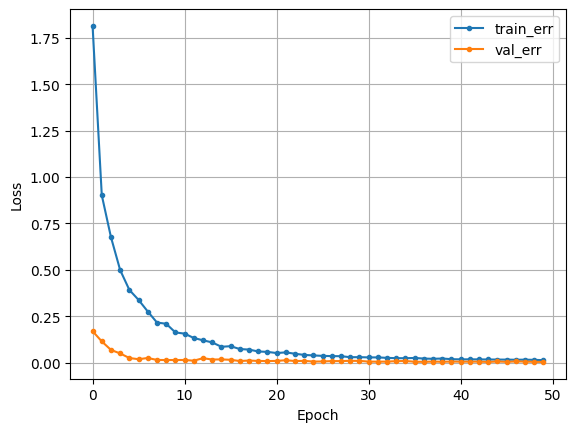

In [ ]:
clear_session()
# 모델선언
model03_02 = Sequential()

# 레이어 조립
# model03_02.add( Input(shape=(timesteps, x_train.shape[2])) )
model03_02.add( keras.layers.Input(shape=(timesteps, x_train.shape[2])) )
model03_02.add(Conv1D(filters=128,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model03_02.add( keras.layers.BatchNormalization() )
model03_02.add( keras.layers.Dropout(0.25) )

model03_02.add(Conv1D(filters=64,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model03_02.add( keras.layers.BatchNormalization() )
model03_02.add( keras.layers.Dropout(0.25) )

model03_02.add(Conv1D(filters=32,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model03_02.add( keras.layers.BatchNormalization() )
model03_02.add( keras.layers.Dropout(0.25) )

model03_02.add(Conv1D(filters=16,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model03_02.add( keras.layers.BatchNormalization() )
model03_02.add( keras.layers.Dropout(0.25) )

model03_02.add(Flatten())
model03_02.add(Dense(1))

model03_02.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')
history = model03_02.fit(x_train, y_train, epochs=50, validation_split=0.2,verbose=0).history
dl_history_plot(history)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_02.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_val2, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 [==============================] - 0s 8ms/step
RMSE:  3295.696619449879
MAE :  2377.690152994792
MAPE :  9.994768870685366e+17
R2 :  0.3109290806343772


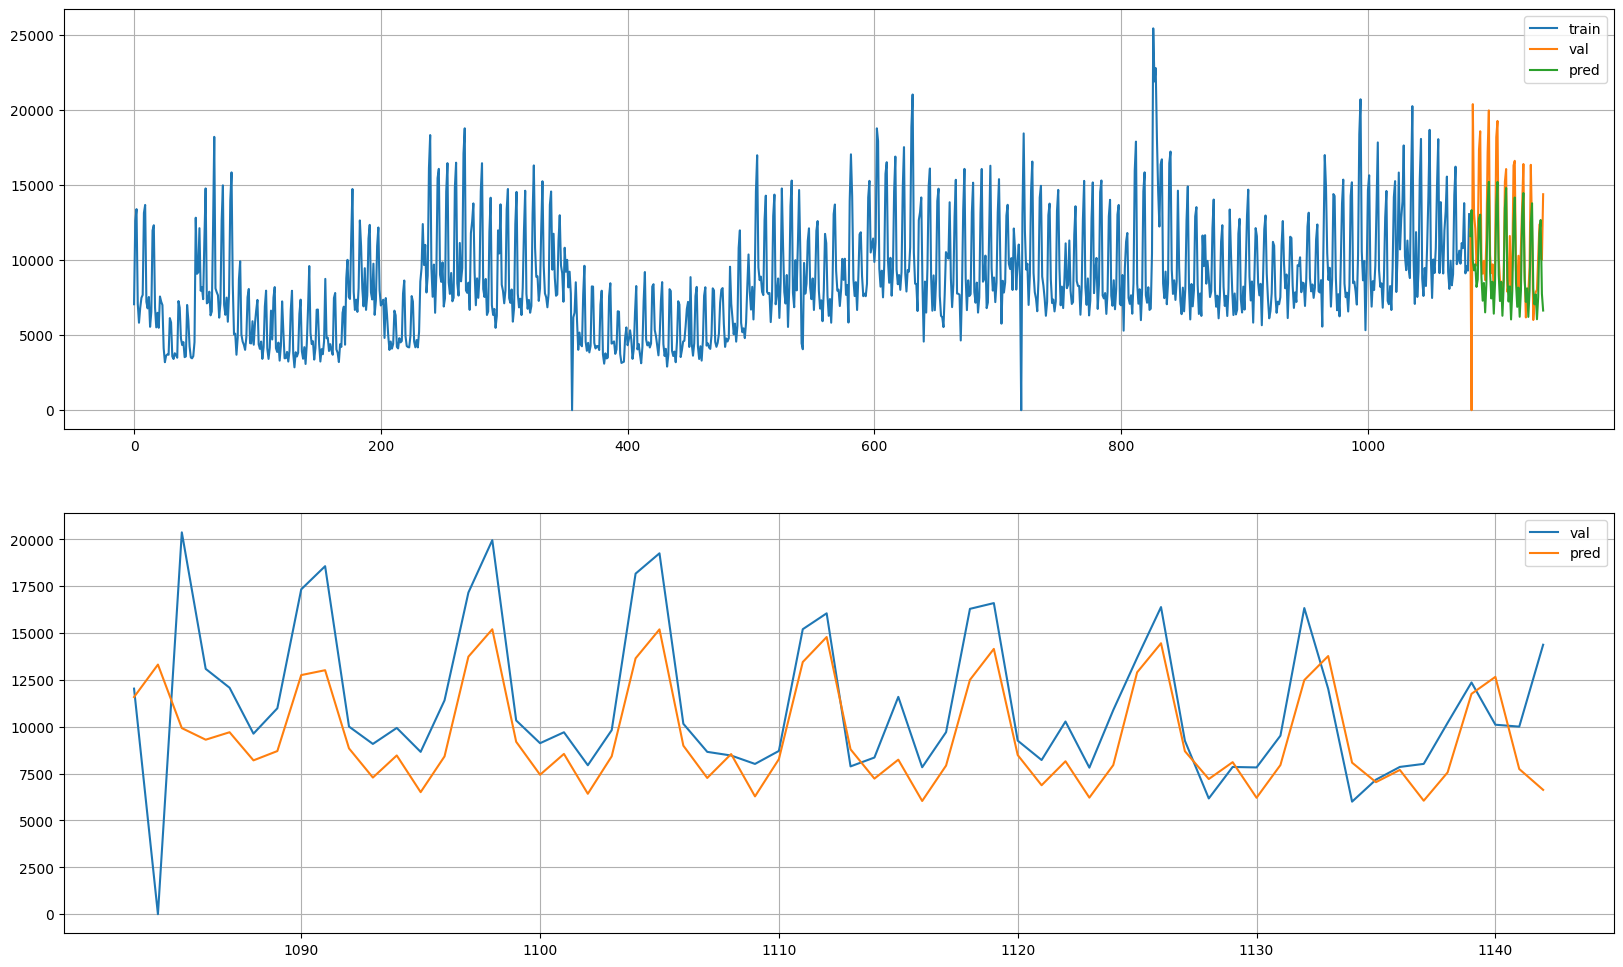

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_44_12, timesteps, True)

* **모델링**

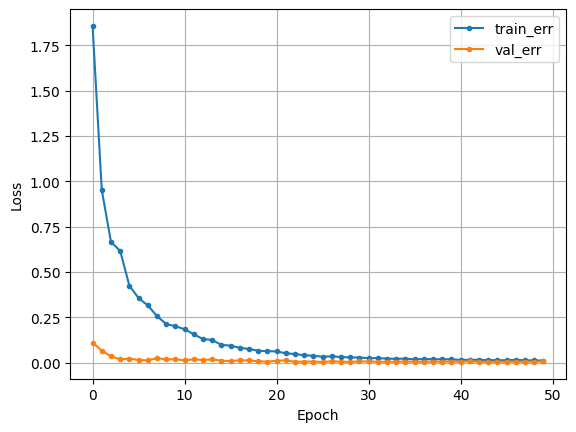

In [ ]:
clear_session()
# 모델선언
model12_02 = Sequential()

# 레이어 조립
model12_02.add( keras.layers.Input(shape=(timesteps, x_train.shape[2])) )
model12_02.add(Conv1D(filters=128,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model12_02.add( keras.layers.BatchNormalization() )
model12_02.add( keras.layers.Dropout(0.25) )

model12_02.add(Conv1D(filters=64,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model12_02.add( keras.layers.BatchNormalization() )
model12_02.add( keras.layers.Dropout(0.25) )

model12_02.add(Conv1D(filters=32,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model12_02.add( keras.layers.BatchNormalization() )
model12_02.add( keras.layers.Dropout(0.25) )

model12_02.add(Conv1D(filters=16,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model12_02.add( keras.layers.BatchNormalization() )
model12_02.add( keras.layers.Dropout(0.25) )

model12_02.add(Flatten())
model12_02.add(Dense(1))

model12_02.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')
history = model12_02.fit(x_train, y_train, epochs=50, validation_split=0.2,verbose=0).history
dl_history_plot(history)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_02.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_val2, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 [==============================] - 0s 10ms/step
RMSE:  3809.9605106385475
MAE :  2911.7198893229165
MAPE :  1.0185222609809965e+18
R2 :  -0.18122032895692342


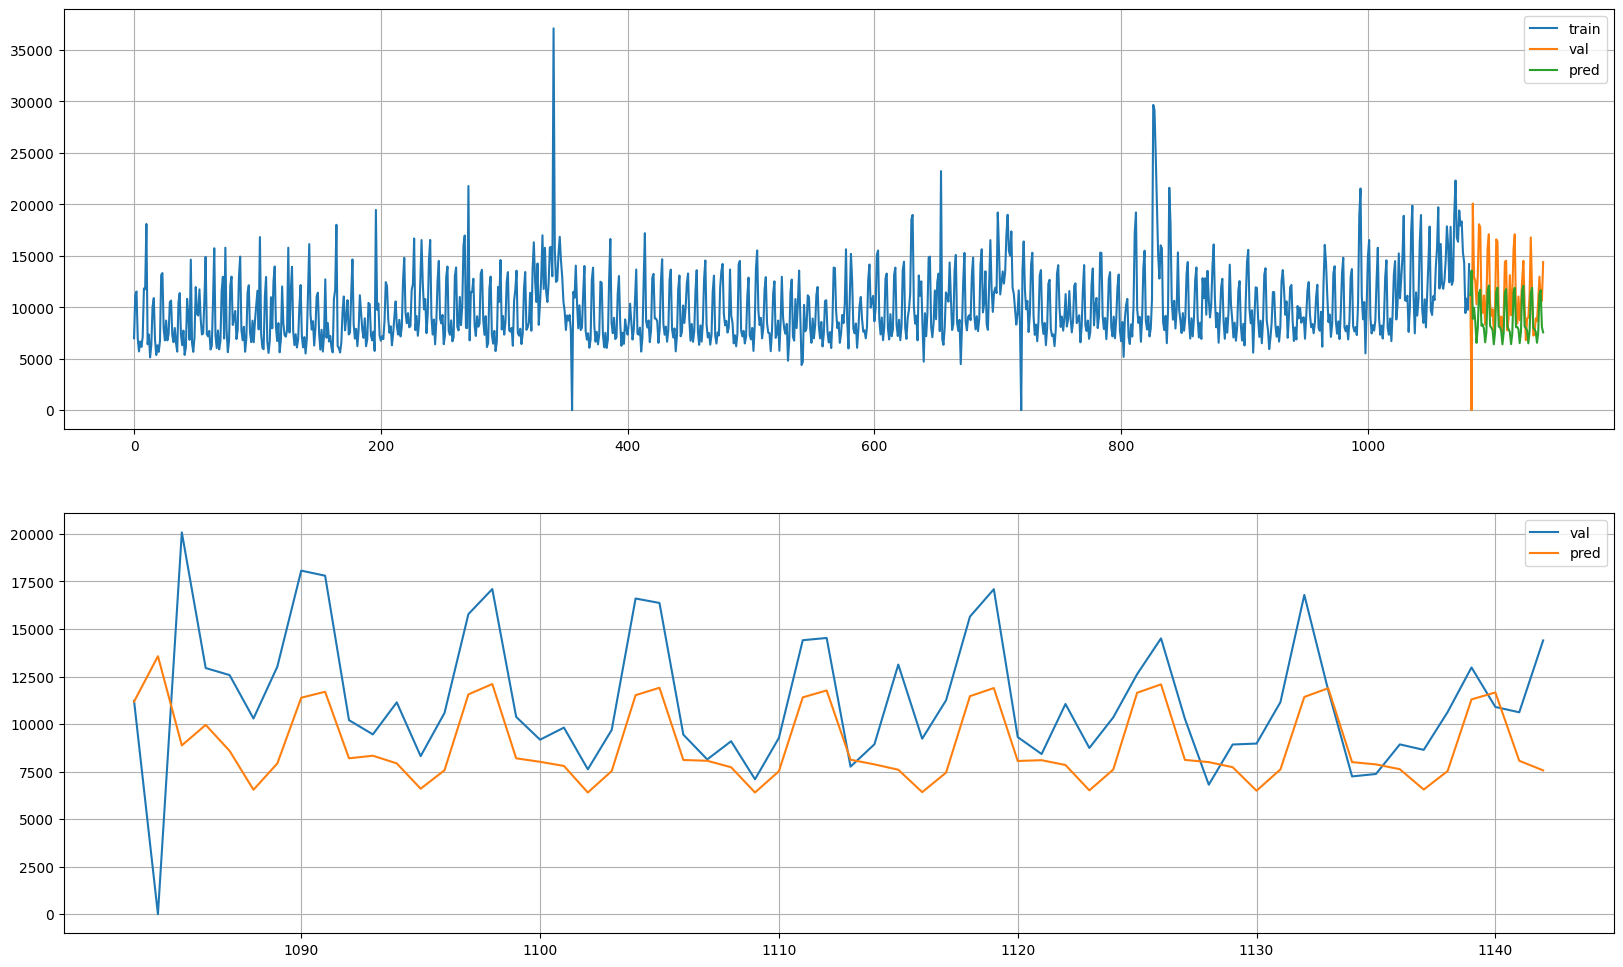

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(sales_44_42, timesteps, True)

* **모델링**

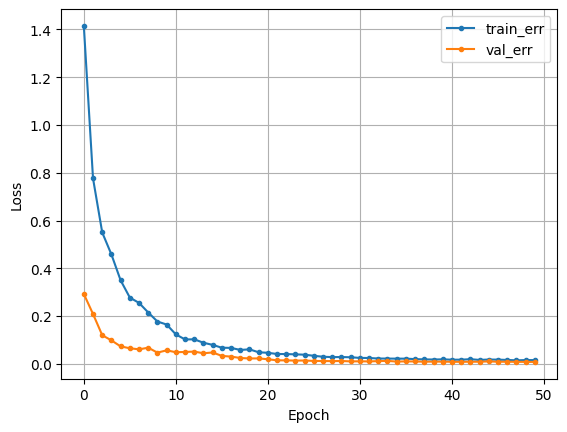

In [ ]:
clear_session()
# 모델선언
model42_02 = Sequential()

# 레이어 조립
model42_02.add( keras.layers.Input(shape=(timesteps, x_train.shape[2])) )
model42_02.add(Conv1D(filters=128,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model42_02.add( keras.layers.BatchNormalization() )
model42_02.add( keras.layers.Dropout(0.25) )

model42_02.add(Conv1D(filters=64,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model42_02.add( keras.layers.BatchNormalization() )
model42_02.add( keras.layers.Dropout(0.25) )

model42_02.add(Conv1D(filters=32,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model42_02.add( keras.layers.BatchNormalization() )
model42_02.add( keras.layers.Dropout(0.25) )

model42_02.add(Conv1D(filters=16,
                      kernel_size=(7,),
                      strides=1,
                      padding='same',
                      activation='relu'))
model42_02.add( keras.layers.BatchNormalization() )
model42_02.add( keras.layers.Dropout(0.25) )

model42_02.add(Flatten())
model42_02.add(Dense(1))

model42_02.compile(optimizer= Adam(learning_rate = 0.001) ,loss='mse')
history = model42_02.fit(x_train, y_train, epochs=50, validation_split=0.2,verbose=0).history
dl_history_plot(history)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_02.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_val2, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

2/2 [==============================] - 0s 9ms/step
RMSE:  11.36025772430782
MAE :  8.906822713216146
MAPE :  0.10723786969377239
R2 :  0.43889677791031323


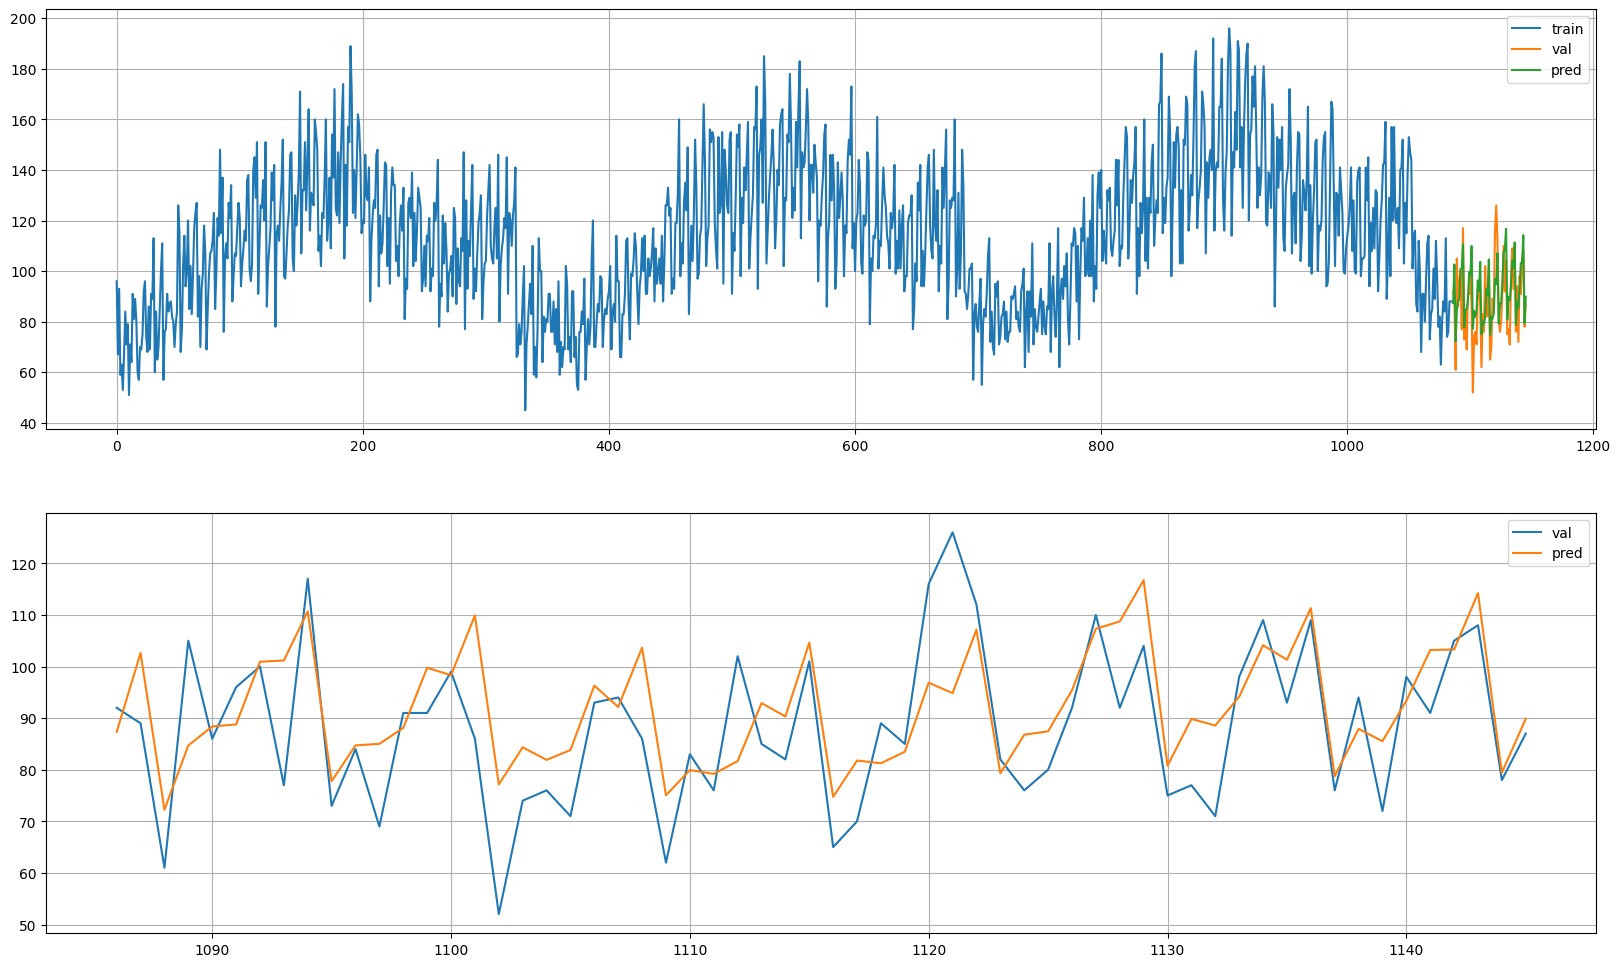

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [ ]:
def preproc4d(data, timesteps, y_scale = False) :
    target = 'Qty_2day'
    x = data.drop(target, axis = 1)
    y = data.loc[:, target]

    col_names = list(x)

    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x_test, y_test = temporalize(x, y, timesteps)

    return x_test, y_test, scaler, y_min, y_max

In [ ]:
def preprocessing4predict(sales_test, orders_test, oil_price_test, products, stores, Product_ID):
    sales_44 = sales_test[sales_test['Store_ID']==44]
    sales_44 = sales_44[sales_44['Product_ID']==Product_ID]
    # 요일, 달, 연도 추가
    sales_44['week'] = sales_44['Date'].dt.day_name()
    sales_44['month'] = sales_44['Date'].dt.month
    # 구매자수 추가
    sales_44 = pd.merge(sales_44, orders_test, how='left')
    # 유가데이터를 그냥 병합하면 너무 많은 데이터가 날라감. (왼쪽데이터는 다 살림)
    sales_44 = pd.merge(sales_44, oil_price_test, how='left')
    # 7일 (이동)평균, 이틀후 변화량, 판매량(target)
    sales_44['Qty_mean_7'] = sales_44['Qty'].rolling(7, min_periods=1).mean()
    sales_44['Qty_diff'] = sales_44['Qty'].shift(-2) - sales_44['Qty']
    sales_44['Qty_2day'] = sales_44['Qty'].shift(-2)
    # 필요없는 열 삭제
    sales_44.drop(['Store_ID', 'Product_ID'], axis=1, inplace=True)
    # NaN 조치 (CustomerCount, WTI_Price, Qty_diff)
    sales_44['CustomerCount'] = sales_44['CustomerCount'].fillna(method='ffill', limit=7)
    sales_44['WTI_Price'].fillna(method='ffill', inplace=True)
    sales_44.dropna(axis=0, inplace=True)
    # 'Date' 컬럼 인덱스로 넣기 + 가변수화
    sales_44.set_index('Date', inplace=True)
    sales_44 = pd.get_dummies(sales_44, columns = ['week'], drop_first=True, dtype=int)

    timesteps = 7
    x_test, y_test, scaler, y_min, y_max = preproc4d(sales_44, timesteps, True)


    return x_test, y_test, scaler, y_min, y_max

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [ ]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [ ]:
x_test.shape, y_test.shape

((23, 7, 12), (23,))

* 예측해보기

In [ ]:
# 3번 상품 판매량 예측
x_test, y_test, scaler, y_min, y_max = preprocessing4predict(sales_test, orders_test, oil_price_test, products, stores, 3)

# 스케일링 된 데이터 돌려서 평가하기
# LSTM 모델
pred = model03_01.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_test = y_test * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_test, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_test, pred))
print('MAPE : ',mean_absolute_percentage_error(y_test, pred))
print('R2 : ',r2_score(y_test, pred))

1/1 [==============================] - 0s 23ms/step
RMSE:  4383.313221376039
MAE :  4296.941491168478
MAPE :  0.4375799037040267
R2 :  -0.09201907942490894


In [ ]:
# 12번 상품 판매량 예측
x_test, y_test, scaler, y_min, y_max = preprocessing4predict(sales_test, orders_test, oil_price_test, products, stores, 12)
# 스케일링 된 데이터 돌려서 평가하기
# LSTM 모델
pred = model12_01.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_test = y_test * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_test, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_test, pred))
print('MAPE : ',mean_absolute_percentage_error(y_test, pred))
print('R2 : ',r2_score(y_test, pred))

1/1 [==============================] - 0s 24ms/step
RMSE:  852.4423394058443
MAE :  677.6273777173913
MAPE :  0.06943154415280336
R2 :  0.9333550685282657


In [ ]:
# 42번 상품 판매량 예측
x_test, y_test, scaler, y_min, y_max = preprocessing4predict(sales_test, orders_test, oil_price_test, products, stores, 42)
# 스케일링 된 데이터 돌려서 평가하기
# LSTM 모델
pred = model42_01.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_test = y_test * (y_max - y_min) + y_min

print('RMSE: ', (mean_squared_error(y_test, pred))**(0.5))
print('MAE : ', mean_absolute_error(y_test, pred))
print('MAPE : ',mean_absolute_percentage_error(y_test, pred))
print('R2 : ',r2_score(y_test, pred))

1/1 [==============================] - 0s 194ms/step
RMSE:  9.468074932345589
MAE :  8.273633873980978
MAPE :  0.07423676080188134
R2 :  0.6354292082546643


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**
#### 3번 price(가격) = 8
#### 12번 price(가격) = 6
#### 42번 price(가격) = 5
#### safe_stock : 안전재고량
#### 안전재고량을 조절하여, 기회손실 수량이 0일때 가장 낮은 안전재고량을 선택하라
#### 그때의 일평일 재고금액이 낮을 수록 좋음

In [ ]:
# 3번 상품 판매량 예측
x_test, y_test, scaler, y_min, y_max = preprocessing4predict(sales_test, orders_test, oil_price_test, products, stores, 3)
# 스케일링 된 데이터 돌려서 평가하기
# LSTM 모델
pred = model03_01.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_test = y_test * (y_max - y_min) + y_min

price = 8
safe_stock = 0
inv_simulator(y_test, pred, safe_stock, price)

1/1 [==============================] - 0s 29ms/step
일평균 재고량     : 10039.286
일평균 재고 금액  : 80314.288
일평균 재고회전율 : 1.213
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,14147.0,8816,0,18582,8816,0.0
1,10087.0,14745.0,10087,0,21231,10087,0.0
2,15131.0,18582.0,18582,3451,10121,18582,0.0
3,18556.0,21231.0,24682,6126,6982,21231,0.0
4,8803.0,13572.0,16247,7444,6123,10121,0.0
5,8690.0,13108.0,14426,5736,6692,6982,0.0
6,9199.0,13567.0,11859,2660,12323,6123,0.0
7,8148.0,12428.0,9352,1204,18783,6692,0.0
8,11616.0,14983.0,13527,1911,21820,12323,0.0
9,16510.0,19987.0,20694,4184,10247,18783,0.0


In [ ]:
# 12번 상품 판매량 예측
x_test, y_test, scaler, y_min, y_max = preprocessing4predict(sales_test, orders_test, oil_price_test, products, stores, 12)
# 스케일링 된 데이터 돌려서 평가하기
# LSTM 모델
pred = model12_01.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_test = y_test * (y_max - y_min) + y_min

price = 6
safe_stock = 6700
inv_simulator(y_test, pred, safe_stock, price)

1/1 [==============================] - 0s 27ms/step
일평균 재고량     : 12503.69
일평균 재고 금액  : 75022.14
일평균 재고회전율 : 0.949
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8208.0,8127.0,14908,6700,13760,8208,0.0
1,9083.0,8859.0,15783,6700,15969,9083,0.0
2,14392.0,13760.0,20460,6068,10222,13760,0.0
3,16478.0,15969.0,22037,5559,9989,15969,0.0
4,8715.0,9590.0,15781,7066,9983,10222,0.0
5,7505.0,8848.0,17055,9550,5829,9989,0.0
6,10453.0,10349.0,19533,9080,8170,9983,0.0
7,8592.0,8679.0,14909,6317,15683,5829,0.0
8,11463.0,10550.0,14487,3024,19855,8170,0.0
9,16763.0,15300.0,18707,1944,14540,15683,0.0


In [ ]:
# 42번 상품 판매량 예측
x_test, y_test, scaler, y_min, y_max = preprocessing4predict(sales_test, orders_test, oil_price_test, products, stores, 42)
# 스케일링 된 데이터 돌려서 평가하기
# LSTM 모델
pred = model42_01.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_test = y_test * (y_max - y_min) + y_min

price = 5
safe_stock = 70
inv_simulator(y_test, pred, safe_stock, price)

1/1 [==============================] - 0s 27ms/step
일평균 재고량     : 127.238
일평균 재고 금액  : 636.19
일평균 재고회전율 : 0.978
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,110.0,107.0,180,70,120,110,0.0
1,101.0,110.0,171,70,124,101,0.0
2,131.0,120.0,190,59,114,120,0.0
3,145.0,124.0,183,38,152,124,0.0
4,90.0,103.0,152,62,108,114,0.0
5,110.0,120.0,214,104,76,152,0.0
6,107.0,100.0,212,105,87,108,0.0
7,108.0,110.0,181,73,110,76,0.0
8,136.0,122.0,160,24,180,87,0.0
9,119.0,113.0,134,15,158,110,0.0
